In [1]:
import torch
from torch import nn
import pandas as pd
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.datasets as dset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [2]:
# Configuration parameters for training a Vision Transformer on MNIST dataset
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 100
LEARNING_RATE = 1e-4
NC = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNEL = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = 'gelu'
NUM_ENCODE = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNEL
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channel):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channel,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),
            nn.Flatten(2))

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channel, embed_dim)), requires_grad=True)
        self.position_embedding = nn.Parameter(torch.randn(size=(1, num_patches + 1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = self.patcher(x).transpose(1, 2)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.position_embedding
        x = self.dropout(x)
        return x


In [4]:
model = PatchEmbedding(embed_dim=EMBED_DIM,
                       patch_size=PATCH_SIZE,
                       num_patches=NUM_PATCHES,
                       dropout=DROPOUT,
                       in_channel=IN_CHANNEL,).to(device)

In [5]:
x = torch.randn(512, 1, 28, 28, device=device) # Ensure input tensor is on the same device as the model
print(model(x).shape)

torch.Size([512, 50, 16])


In [6]:
class ViT(nn.Module):
    def __init__(self, num_patches, num_classes, embed_dim, num_encode, num_heads, hidden_dim, dropout, activation, in_channel):
        super().__init__()
        self.embedding_block = PatchEmbedding(embed_dim, patch_size=PATCH_SIZE, num_patches=num_patches, dropout=dropout, in_channel=in_channel)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encode)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes))

    def forward(self, x):
        x = self.embedding_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])
        return x
model = ViT(num_patches=NUM_PATCHES,
            num_classes=NC,
            embed_dim=EMBED_DIM,
            num_encode=NUM_ENCODE,
            num_heads=NUM_HEADS,
            hidden_dim=HIDDEN_DIM,
            dropout=DROPOUT,
            activation=ACTIVATION,
            in_channel=IN_CHANNEL).to(device)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [7]:
x = torch.randn(512, 1, 28, 28, device=device)  # Ensure input tensor is on the same device as the model
print(model(x).shape)

torch.Size([512, 10])


In [8]:
train_dataset = dset.MNIST(root='./data',
                              train=True,
                              transform=transforms.ToTensor(),
                              download=True)
test_dataset = dset.MNIST(root='./data',
                             train=False,
                             transform=transforms.ToTensor(),
                             download=True)

train_data, val_data = train_test_split(list(train_dataset), test_size=0.1, random_state=RANDOM_SEED, shuffle=True)
train_dataset = torch.utils.data.Subset(train_dataset, [i for i, _ in enumerate(train_data)])
val_dataset = torch.utils.data.Subset(train_dataset, [i for i, _ in enumerate(val_data)])


Text(0.5, 1.0, 'Val Sample')

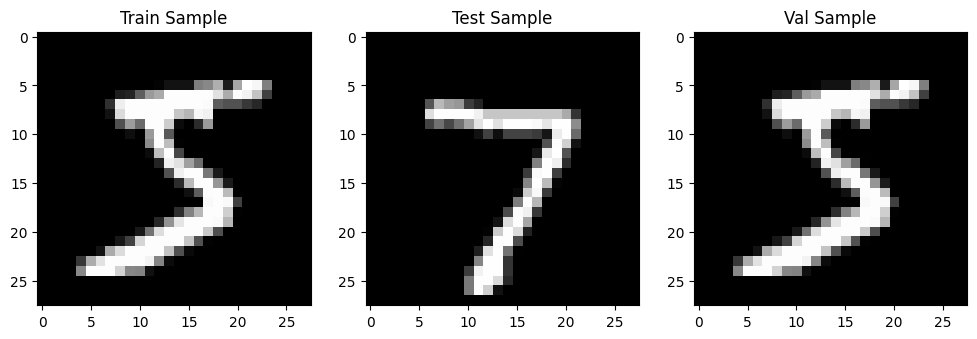

In [9]:
fiq, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(train_dataset[0][0].squeeze(), cmap='gray')
ax[0].set_title('Train Sample')
ax[1].imshow(test_dataset[0][0].squeeze(), cmap='gray')
ax[1].set_title('Test Sample')
ax[2].imshow(val_dataset[0][0].squeeze(), cmap='gray')
ax[2].set_title('Val Sample')

In [10]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, sampler=False)

In [11]:
for images, labels in train_loader:
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels: {labels}")
    break

Images shape: torch.Size([512, 1, 28, 28])
Labels shape: torch.Size([512])
Labels: tensor([2, 1, 1, 1, 6, 5, 6, 5, 1, 2, 6, 7, 3, 4, 2, 6, 7, 4, 7, 5, 3, 0, 9, 6,
        5, 9, 4, 2, 3, 0, 1, 1, 0, 9, 1, 1, 1, 1, 7, 6, 7, 0, 7, 1, 5, 7, 3, 6,
        7, 3, 0, 4, 9, 9, 4, 3, 7, 1, 6, 6, 7, 3, 3, 4, 6, 7, 6, 9, 3, 2, 4, 8,
        2, 6, 6, 8, 8, 3, 7, 0, 6, 2, 9, 3, 7, 8, 1, 7, 4, 2, 8, 0, 2, 3, 7, 7,
        1, 3, 6, 2, 0, 2, 1, 0, 9, 1, 7, 8, 6, 4, 1, 4, 9, 4, 8, 0, 0, 9, 5, 8,
        2, 0, 6, 0, 3, 8, 4, 8, 8, 0, 2, 0, 8, 7, 7, 2, 6, 2, 5, 7, 5, 1, 2, 0,
        3, 2, 5, 2, 4, 0, 3, 3, 0, 4, 3, 2, 6, 9, 5, 1, 8, 2, 1, 3, 8, 1, 0, 8,
        2, 5, 5, 4, 6, 4, 9, 0, 0, 6, 6, 7, 2, 7, 6, 3, 3, 0, 4, 6, 2, 2, 5, 5,
        5, 1, 1, 2, 9, 7, 1, 9, 6, 4, 8, 2, 8, 3, 9, 8, 1, 6, 5, 8, 2, 4, 1, 8,
        1, 4, 1, 1, 5, 3, 3, 6, 5, 3, 2, 1, 4, 6, 0, 7, 9, 2, 1, 8, 6, 0, 3, 0,
        5, 0, 2, 5, 5, 2, 9, 1, 5, 1, 7, 3, 1, 3, 7, 8, 8, 9, 4, 7, 8, 3, 6, 2,
        6, 8, 8, 8, 4, 3, 3, 1, 3, 9,

In [12]:
def training(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    epochs: int,
    device: torch.device,
    verbose: bool = True
):
  criterion = criterion
  optimizer = optimizer

  start = timeit.default_timer()
  out = {
    "total_train_loss" : [],
    "total_val_loss" : [],
    "total_train_acc" : [],
    "total_val_acc" : [],

  }
  for epoch in tqdm(range(epochs), position=0, leave=True):
      model.train()
      train_label = []
      train_pred = []
      train_running_loss = 0
      for idx, (img, label) in enumerate(train_loader):
          img = img.to(device)
          label = label.to(device)
          y_pred = model(img)
          y_pred_label = torch.argmax(y_pred, dim=1)

          train_label.extend(label.cpu().detach())
          train_pred.extend(y_pred_label.cpu().detach())

          loss = criterion(y_pred, label)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          train_running_loss += loss.item()
      train_loss = train_running_loss / (idx + 1)

      model.eval()
      val_label = []
      val_pread = []
      val_running_loss = 0
      with torch.no_grad():
          for idx, (img, label) in enumerate(val_loader):
              img = img.to(device)
              label = label.to(device)
              y_pred = model(img)
              y_pred_label = torch.argmax(y_pred, dim=1)

              val_label.extend(label.cpu().detach())
              val_pread.extend(y_pred_label.cpu().detach())

              loss = criterion(y_pred, label)
              val_running_loss += loss.item()
          val_loss = val_running_loss / (idx + 1)

      out["total_train_loss"].append(train_loss)
      out["total_val_loss"].append(val_loss)
      out["total_train_acc"].append(sum(1 for x, y in zip(train_label, train_pred) if x==y) / len(train_label))
      out["total_val_acc"].append(sum(1 for x, y in zip(val_label, val_pread) if x==y) / len(val_label))

      if verbose and (epoch % 10 == 0 or epoch==0):
          print("\n", "-"*30)
          print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
          print(f"Train Acc EPOCH {epoch+1}: {sum(1 for x, y in zip(train_label, train_pred) if x==y) / len(train_label):.4f}")
          print(f"Val Acc EPOCH {epoch+1}: {sum(1 for x, y in zip(val_label, val_pread) if x==y) / len(val_label):.4f}")
          print("\n", "-"*30)

  end = timeit.default_timer()
  print(f"Training Time: {int((end - start)/60)} minuts and {int((end - start)%60)} seconds")
  return out

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=ADAM_BETAS, weight_decay=ADAM_WEIGHT_DECAY)

results = training(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
)

  0%|          | 0/100 [00:00<?, ?it/s]


 ------------------------------
Epoch [1/100], Train Loss: 2.3030, Val Loss: 2.2714
Train Acc EPOCH 1: 0.1205


  1%|          | 1/100 [00:24<39:40, 24.04s/it]

Val Acc EPOCH 1: 0.1518

 ------------------------------


 10%|█         | 10/100 [03:01<26:17, 17.53s/it]


 ------------------------------
Epoch [11/100], Train Loss: 0.5657, Val Loss: 0.5215
Train Acc EPOCH 11: 0.8617


 11%|█         | 11/100 [03:18<25:59, 17.52s/it]

Val Acc EPOCH 11: 0.8778

 ------------------------------


 20%|██        | 20/100 [05:56<23:27, 17.60s/it]


 ------------------------------
Epoch [21/100], Train Loss: 0.3138, Val Loss: 0.2527
Train Acc EPOCH 21: 0.9150


 21%|██        | 21/100 [06:14<23:12, 17.62s/it]

Val Acc EPOCH 21: 0.9385

 ------------------------------


 30%|███       | 30/100 [08:52<20:30, 17.58s/it]


 ------------------------------
Epoch [31/100], Train Loss: 0.2283, Val Loss: 0.1992
Train Acc EPOCH 31: 0.9338


 31%|███       | 31/100 [09:09<20:07, 17.50s/it]

Val Acc EPOCH 31: 0.9437

 ------------------------------


 40%|████      | 40/100 [11:48<17:36, 17.61s/it]


 ------------------------------
Epoch [41/100], Train Loss: 0.1725, Val Loss: 0.1364
Train Acc EPOCH 41: 0.9496


 41%|████      | 41/100 [12:06<17:28, 17.76s/it]

Val Acc EPOCH 41: 0.9628

 ------------------------------


 50%|█████     | 50/100 [14:42<14:31, 17.44s/it]


 ------------------------------
Epoch [51/100], Train Loss: 0.1413, Val Loss: 0.1174


 51%|█████     | 51/100 [15:00<14:21, 17.59s/it]

Train Acc EPOCH 51: 0.9574
Val Acc EPOCH 51: 0.9650

 ------------------------------


 60%|██████    | 60/100 [17:37<11:36, 17.41s/it]


 ------------------------------
Epoch [61/100], Train Loss: 0.1255, Val Loss: 0.0977


 61%|██████    | 61/100 [17:56<11:28, 17.65s/it]

Train Acc EPOCH 61: 0.9619
Val Acc EPOCH 61: 0.9715

 ------------------------------


 70%|███████   | 70/100 [20:33<08:45, 17.52s/it]


 ------------------------------
Epoch [71/100], Train Loss: 0.1125, Val Loss: 0.0833
Train Acc EPOCH 71: 0.9659


 71%|███████   | 71/100 [20:51<08:29, 17.56s/it]

Val Acc EPOCH 71: 0.9760

 ------------------------------


 80%|████████  | 80/100 [23:28<05:50, 17.50s/it]


 ------------------------------
Epoch [81/100], Train Loss: 0.0987, Val Loss: 0.0790
Train Acc EPOCH 81: 0.9698


 81%|████████  | 81/100 [23:46<05:31, 17.42s/it]

Val Acc EPOCH 81: 0.9777

 ------------------------------


 90%|█████████ | 90/100 [26:24<02:55, 17.52s/it]


 ------------------------------
Epoch [91/100], Train Loss: 0.0895, Val Loss: 0.0814


 91%|█████████ | 91/100 [26:41<02:38, 17.58s/it]

Train Acc EPOCH 91: 0.9717
Val Acc EPOCH 91: 0.9738

 ------------------------------


100%|██████████| 100/100 [29:19<00:00, 17.60s/it]

Training Time: 29 minuts and 19 seconds


In [14]:
torch.save(model.state_dict(), 'ViT_Digits.pth')

Total naumber of true preds is: 98 and Total number of false preds is 2.


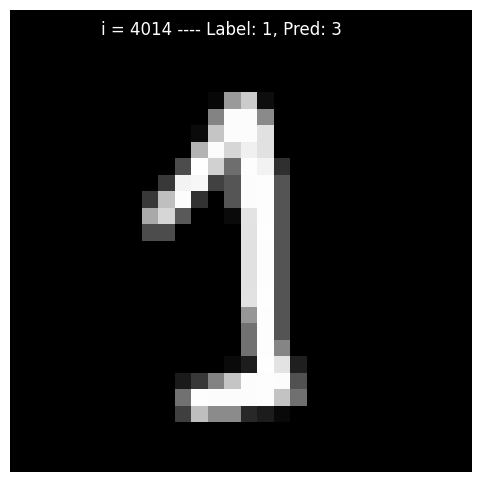

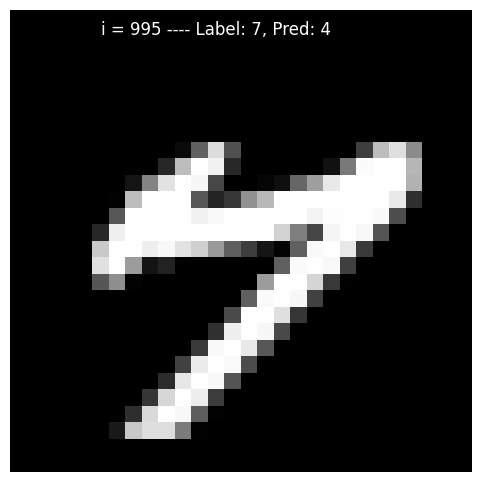

In [ ]:
TP = 0
FN = 0
for i in range(100):
  i = np.random.randint(0, len(val_dataset))
  val_example = val_dataset[i][0].unsqueeze(0).to(device)
  val_label_example = val_dataset[i][1]
  val_pred_example = torch.argmax(model(val_example), dim=1)
  if val_label_example == val_pred_example:
      TP += 1
  else:
      FN += 1
      plt.figure(figsize=(8, 6))
      plt.imshow(val_example.cpu().detach().squeeze(), cmap='gray')
      plt.text(5, 1, f"i = {i} ---- Label: {val_label_example}, Pred: {val_pred_example.item()}",
              color='white', fontsize=12, backgroundcolor='black')
      plt.axis('off')
print(f"Total naumber of true preds is: {TP} and Total number of false preds is {FN}.")

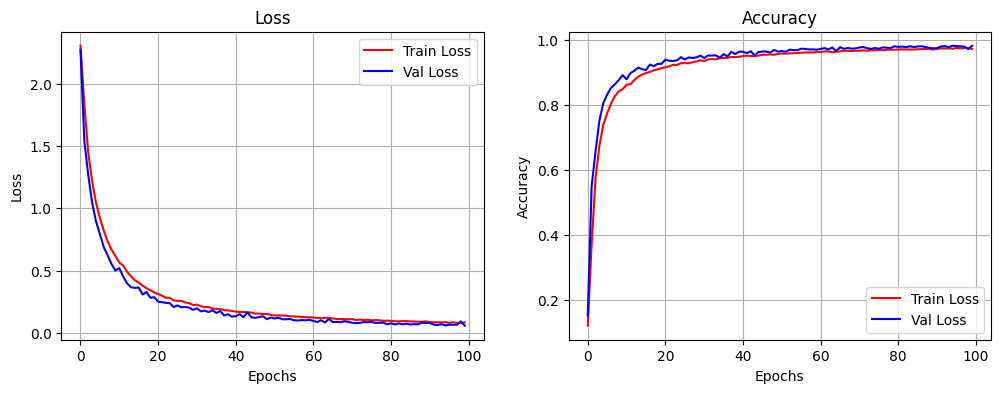

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].grid(True)
ax[0].plot(results["total_train_loss"], label='Train Loss', color='r')
ax[0].plot(results["total_val_loss"],label='Val Loss', color='b')
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].grid(True)
ax[1].plot(results["total_train_acc"], label='Train Loss', color='r')
ax[1].plot(results["total_val_acc"],label='Val Loss', color='b')
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
